<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/3/13 尝试了Dense autoencoder之后，效果一般，勉强能出数字1和9.因此决定尝试convolutional autoencoer

2020/3/14 成功将ssim作为loss function.

In [1]:
from keras.layers import Input, Dense , Dropout
from keras.models import Model
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/


/content/drive/My Drive/Colab Notebooks/MMF data


In [3]:
cd Mnist\ image\ data

/content/drive/My Drive/Colab Notebooks/MMF data/Mnist image data


In [0]:
with open('resize_10000.dat','rb') as f:
  imgs = pickle.load(f)

with open('resize_10000_SLM.dat','rb') as f:
  origins = pickle.load(f)

In [0]:
# for i in range(10000):
#   imgs[i] = imgs[i].flatten()
#   origins[i] = origins[i].flatten()

In [0]:
train_imgs = []
train_origins = []

test_imgs = []
test_origins =[]

for i in range(8000):
  train_imgs.append(imgs[i].reshape(28,28,1))
  train_origins.append(origins[i].reshape(28,28,1))

for i in range(8000,10000):
  test_imgs.append(imgs[i].reshape(28,28,1))
  test_origins.append(origins[i].reshape(28,28,1))


Set up neural network

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [8]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)

In [0]:
encoder = Model(input_img, encoded)

In [0]:
import tensorflow as tf

def ssim_loss(y_true, y_pred):
  return 1.0-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [11]:
autoencoder.compile(optimizer = 'adam', loss = ssim_loss , metrics = [ssim_loss, 'accuracy'])

In [12]:
from keras.datasets import mnist
import numpy as np

train_imgs = np.array(train_imgs).astype('float32') / 255.
train_origins = np.array(train_origins).astype('float32') / 255.

test_imgs = np.array(test_imgs).astype('float32') / 255.
test_origins = np.array(test_origins).astype('float32') / 255.


print (train_imgs.shape)
print (test_imgs.shape)

(8000, 28, 28, 1)
(2000, 28, 28, 1)


In [13]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0   

In [14]:
history = autoencoder.fit(train_imgs, train_origins,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(test_imgs, test_origins))




Train on 8000 samples, validate on 2000 samples
Epoch 1/150





8000/8000 [==============================] - 5s 628us/step - loss: 0.8449 - ssim_loss: 0.8449 - acc: 0.6601 - val_loss: 0.8067 - val_ssim_loss: 0.8067 - val_acc: 0.7378
Epoch 2/150
8000/8000 [==============================] - 2s 215us/step - loss: 0.7797 - ssim_loss: 0.7797 - acc: 0.7657 - val_loss: 0.7859 - val_ssim_loss: 0.7859 - val_acc: 0.7507
Epoch 3/150
8000/8000 [==============================] - 2s 216us/step - loss: 0.7568 - ssim_loss: 0.7568 - acc: 0.7710 - val_loss: 0.7490 - val_ssim_loss: 0.7490 - val_acc: 0.7675
Epoch 4/150
8000/8000 [==============================] - 2s 217us/step - loss: 0.7318 - ssim_loss: 0.7318 - acc: 0.7677 - val_loss: 0.7266 - val_ssim_loss: 0.7266 - val_acc: 0.7448
Epoch 5/150
8000/8000 [==============================] - 2s 214us/step - loss: 0.6923 - ssim_loss: 0.6923 - acc: 0.7659 - val_loss: 0.7120 - val_ssim_loss: 0.7120 - val_acc: 0.7550
Epoch 6/150
8000/8000 [================

In [0]:
decoded_imgs = autoencoder.predict(test_imgs)

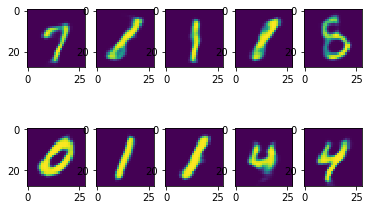

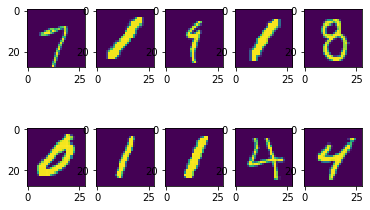

In [17]:
import matplotlib.pyplot as plt

images = decoded_imgs.reshape(-1,28,28)

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i])
plt.show()

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_origins[i].reshape(28,28))
plt.show()